In [1]:
from collections import defaultdict
import copy
import facebook
import io
import matplotlib.pyplot as plt
import networkx as nx
import time
%matplotlib inline

In [2]:
def read_graph():
    edges = [tuple((line.strip().split('\t'))) for line in open("edges.txt")]
    d = defaultdict(list)
    for k,v in edges:
        d[k].append(v)
    
    G = nx.Graph()
    
    #add nodes to the graph
    list_of_nodes =[]
    for key in d:
        for value in range(0,len(d[key])):
            list_of_nodes.append(d[key][value])
    nodes_set = set(list_of_nodes)
    G.add_nodes_from(nodes_set)
    
    #add edges to the graph
    G.add_edges_from(edges)
    return G

graph = read_graph()
print('graph has %d nodes and %d edges' % 
      (graph.order(), graph.number_of_edges()))

graph has 5062 nodes and 6060 edges


In [3]:
# Nodes with highest degree.
sorted(graph.degree().items(), key=lambda x: x[1], reverse=True)[:10]

[('ONE', 39),
 ('Bill & Melinda Gates Foundation', 39),
 ('NPR', 35),
 ('UN Women', 34),
 ('The New York Times', 34),
 ('Women Deliver', 34),
 ('I fucking love science', 33),
 ('Global Citizen', 33),
 ('Melinda Gates', 32),
 ('World Health Organization (WHO)', 32)]

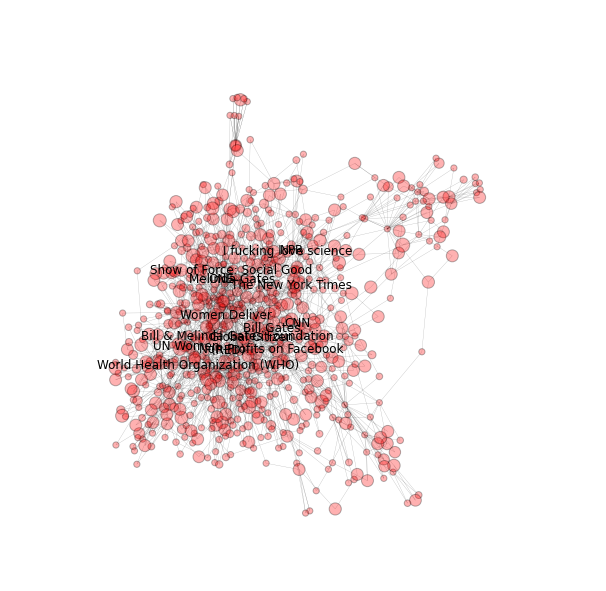

In [4]:
#Drawing graph
def draw_network(graph, draw_thresh=1, label_thresh=31,
                 min_node_sz=30, max_node_sz=200):
    """
    Draw a graph, filtering the nodes and labels based on degree.
    The size of nodes is proportional to degree.
    
    graph...........a networkx graph
    draw_thresh.....only draw nodes that have degree greater than this.
    label_thresh....only label nodes that have degree greater than this.
    min_node_size...smallest node size
    max_node_size...biggest node size
    """
    degrees = graph.degree()
    labels = {n: n for n, d in degrees.items() if d > label_thresh}
    plt.figure(figsize=(10,10))
    nodes_to_draw = [name for name, degree in degrees.items() if degree > draw_thresh]
    maxdegree = max(degrees.values())
    sz_range = max_node_sz - min_node_sz
    sizes = [min_node_sz + (1. * degrees[n] / maxdegree * sz_range)
             for n in nodes_to_draw]
    subgraph = graph.subgraph(nodes_to_draw)
    nx.draw_networkx(subgraph, alpha=.3, width=.3,
                     labels=labels, node_size=sizes)
    plt.axis("off")
    plt.show()
    
draw_network(graph)

# Community Detection

In [5]:
#Backscaling graph size 
def get_subgraph(graph, min_degree):
    """Return a subgraph containing nodes whose degree is
    greater than min_degree.
    Args:
      graph........a networkx graph
      min_degree...degree threshold
    Returns:
      a networkx graph, filtered as defined above.
    """
    degrees = graph.degree()
    node_list =[]
    for r in degrees:
        if degrees[r] <= min_degree:
            node_list.append(r)
    graph.remove_nodes_from(node_list)
    return graph

subgraph = get_subgraph(graph, 1)
print('subgraph has %d nodes and %d edges' % 
      (subgraph.order(), subgraph.number_of_edges()))

subgraph has 712 nodes and 1710 edges


In [6]:
def girvan_newman(G, minsize=30, maxsize=100):
    
    def find_best_edge(G0):
        eb = nx.edge_betweenness_centrality(G0)
        return sorted(eb.items(), key=lambda x: x[1], reverse=True)
    
    result=[]
    count=0
    if len(G.nodes()) > maxsize:
        edge_to_remove_dictionary = find_best_edge(G)
        edge_to_remove = edge_to_remove_dictionary.pop(0)
        G.remove_edge(*(edge_to_remove[0]))
        count += 1
        
    new_components = [c for c in nx.connected_component_subgraphs(G)]    

    while (len(new_components) == 1):
        if(len(G.nodes()) > maxsize):
            edge_to_remove = edge_to_remove_dictionary.pop(0)
            G.remove_edge(*(edge_to_remove[0]))
            count += 1
            new_components = [c for c in nx.connected_component_subgraphs(G)]
        else:
            break
    print "removed %d edges"% count    
    
    component_list =[]
    for i in new_components:
        component_list.append(len(i.nodes())) 
    print "component sizes=" , component_list
                                                                         
    for n in new_components:
        if (len(n.nodes()) >= minsize) and (len(n.nodes()) <= maxsize):
            print "stopping for %s" % len(n.nodes())
            result.append(n.nodes())
        else:
            if(len(n.nodes()) > maxsize):
                result.extend(girvan_newman(n,minsize,maxsize))
    
    return result

result = girvan_newman(subgraph.copy(), minsize=30, maxsize=100) 

removed 87 edges
component sizes= [701, 11]
removed 3 edges
component sizes= [695, 6]
removed 6 edges
component sizes= [694, 1]
removed 2 edges
component sizes= [693, 1]
removed 3 edges
component sizes= [692, 1]
removed 6 edges
component sizes= [691, 1]
removed 2 edges
component sizes= [689, 2]
removed 2 edges
component sizes= [688, 1]
removed 1 edges
component sizes= [641, 47]
removed 188 edges
component sizes= [634, 7]
removed 4 edges
component sizes= [633, 1]
removed 12 edges
component sizes= [632, 1]
removed 8 edges
component sizes= [631, 1]
removed 6 edges
component sizes= [630, 1]
removed 2 edges
component sizes= [629, 1]
removed 2 edges
component sizes= [628, 1]
removed 1 edges
component sizes= [600, 28]
removed 6 edges
component sizes= [599, 1]
removed 6 edges
component sizes= [598, 1]
removed 2 edges
component sizes= [597, 1]
removed 1 edges
component sizes= [557, 40]
removed 25 edges
component sizes= [554, 3]
removed 13 edges
component sizes= [553, 1]
removed 1 edges
componen

In [7]:
print('final cluster sizes:')
[len(x) for x in result]

final cluster sizes:


[100, 68, 100, 32, 40, 47]

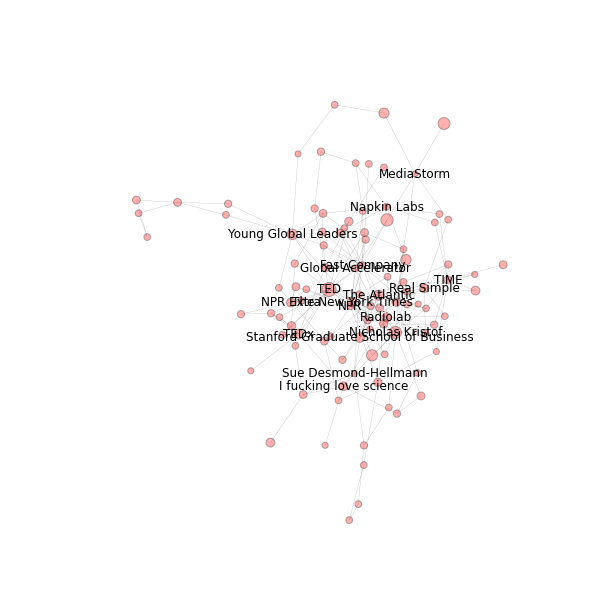

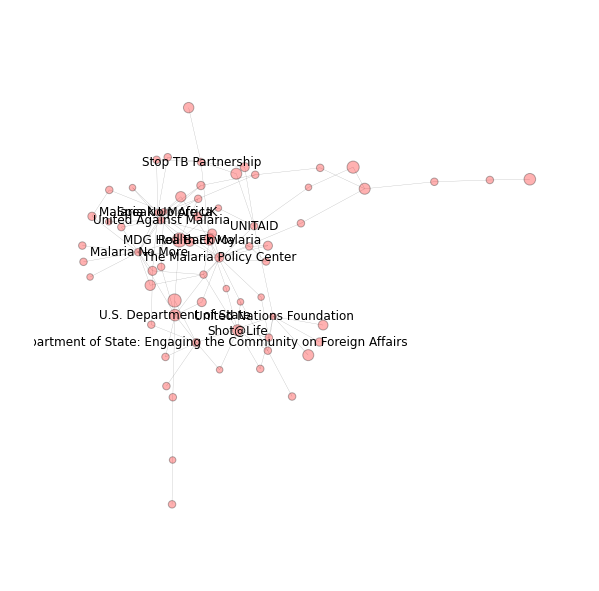

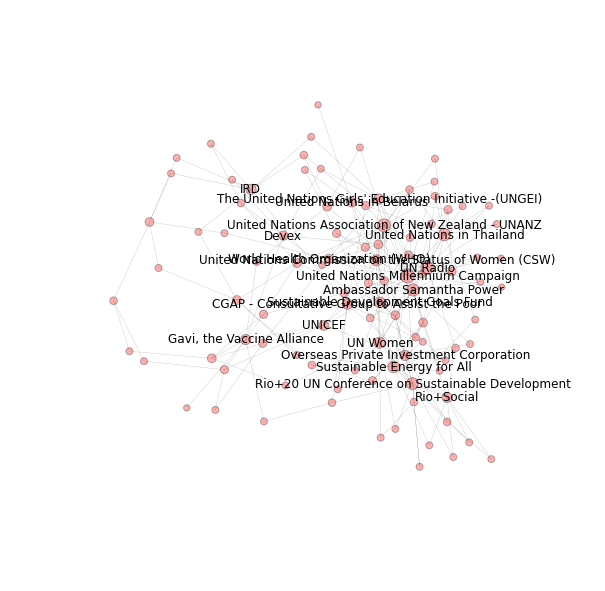

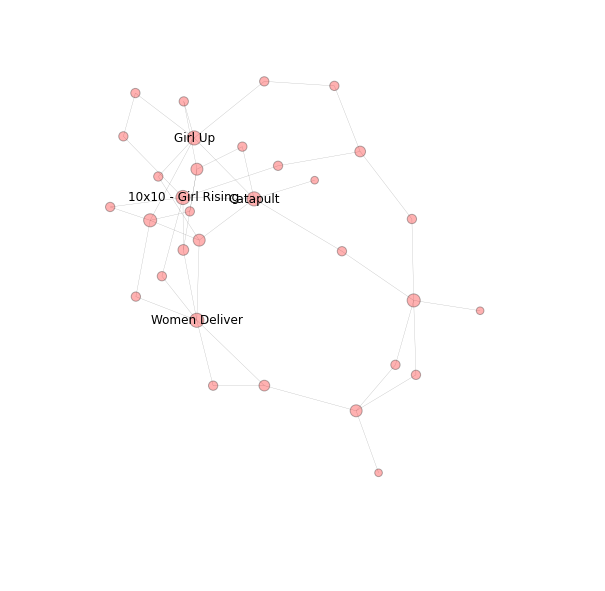

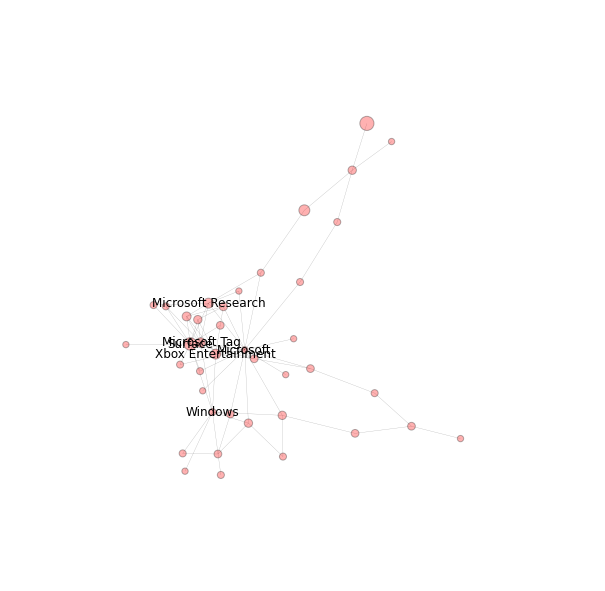

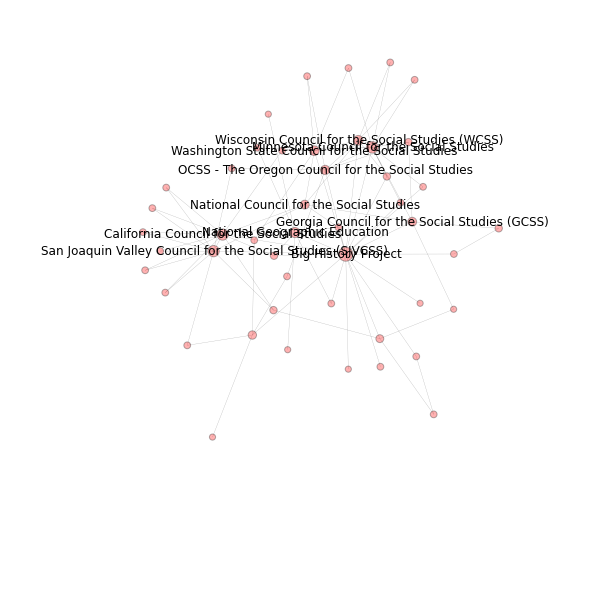

In [8]:
# Draw each cluster separately.
for cluster in result:
    draw_network(graph.subgraph(cluster), label_thresh=5, draw_thresh=0)

In [9]:
# Compute the normalized cut for each discovered cluster.
def volume(nodes, graph):
    """
    Compute the volume for a set of `nodes`, which
    is the number of edges in `graph` with at least one end in
    nodes.
    Args:
      nodes...a list of strings for the nodes to compute the volume of.
      graph...a networkx graph 
    """
    vol = 0
    for edge in graph.edges():
        if (edge[0] in nodes) or (edge[1] in nodes):
            vol += 1
    return vol
        
def cut(S, T, graph):
    """
    Compute the cut-set of the cut (S,T), which is
    the set of edges that have one endpoint in S and
    the other in T.
    Args:
      S.......set of nodes in first subset
      T.......set of nodes in second subset
      graph...networkx graph
    Returns:
      An int representing the cut-set.
    """
    cutset_list = []
    for edge in nx.edges(graph):
        if ((edge[0] in S) and (edge[1] in T)) or ((edge[0] in T) and (edge[1] in S)): #DRK or added
            cutset_list.append(edge)
    return len(cutset_list)

def norm_cut_v(S, T, graph):
    """
    The normalized cut value for the cut S/T. (See lec06.)
    Args:
      S.......set of nodes in first subset
      T.......set of nodes in second subset
      graph...networkx graph
    Returns:
      An float representing the normalized cut value
    """
    ncv = ((cut(S, T, graph))/float(volume(S, graph))) + ((cut(S, T, graph))/float(volume(T, graph)))    
    return ncv

def score_clusters(clusters, graph):
    ncv_list=[]
    for c in clusters:
        remainder_graph = set(graph.nodes()) - set(c)
        ncv_list.append(norm_cut_v(c,remainder_graph,graph))
    return ncv_list
    
score_clusters(result, subgraph)   

[0.5394522186431889,
 0.7112986541855564,
 0.6125866583993509,
 0.7394497863247863,
 0.38487710745480397,
 0.169372331833391]

# Link Prediction

In [10]:
test_node = 'Bill Gates'
G_train = subgraph.copy()
edges_to_rem = subgraph.edges(test_node)[:10]
G_train.remove_edges_from(edges_to_rem)
print('original graph has %d nodes and %d edges' % 
      (subgraph.order(), subgraph.number_of_edges()))
print('train graph has %d nodes and %d edges' % 
      (G_train.order(), G_train.number_of_edges()))

original graph has 712 nodes and 1710 edges
train graph has 712 nodes and 1700 edges


In [11]:
print('removed the following edges:')
edges_to_rem

removed the following edges:


[('Bill Gates', 'Khan Academy'),
 ('Bill Gates', 'Pau Gasol'),
 ('Bill Gates', 'Big History Project'),
 ('Bill Gates', 'PATH'),
 ('Bill Gates', 'Vaccines Today'),
 ('Bill Gates', 'World Health Organization'),
 ('Bill Gates', 'TED'),
 ('Bill Gates', 'Bill & Melinda Gates Foundation'),
 ('Bill Gates', 'ONE'),
 ('Bill Gates', 'Sue Desmond-Hellmann')]

In [12]:
# Professor's method
def evaluate(scores, graph, n=10):
    """ Returns the accuracy of the predicted link scores, filtering
        to the top `n` results.
    Args:
      scores....list of ((n1, n2), score) tuples, representing the 
                score assigned to edge (n1, n2)
      graph.....a networkx graph
      n.........Evaluate the top n values in scores.
    Returns:
      A float indicating the proportion of the top ranked edges
      in scores that are present in the graph.
    """
    predicted_edges = [x[0] for x in sorted(scores, key=lambda x: x[1], reverse=True)[:n]]
    return 1. * len([x for x in predicted_edges if graph.has_edge(*x)]) / len(predicted_edges)

In [13]:
# Professor's method.
def jaccard(graph, node):
    """ Jaccard similarity. Note that we don't
    return scores for edges that already appear in the graph.
    """
    scores = []
    neighborsi = set(graph.neighbors(node))
    for n in graph.nodes():
        if n != node and not graph.has_edge(node, n):
            neighborsj = set(graph.neighbors(n))
            score = 1. * (len(neighborsi & neighborsj)) / (len(neighborsi | neighborsj))
            scores.append(((node, n), score))
    return scores

jaccard_scores = jaccard(G_train, test_node)
print('jaccard accuracy=%.3f' % evaluate(jaccard_scores, subgraph, n=10))

jaccard accuracy=0.200


In [14]:
print('%d jaccard scores' % len(jaccard_scores))
print('top 5 recommendations:')
[x[0][1] for x in sorted(jaccard_scores, key=lambda x: x[1], reverse=True)[:5]]

690 jaccard scores
top 5 recommendations:


['Global Citizen',
 'Girl Effect',
 'Show of Force: Social Good',
 'Sue Desmond-Hellmann',
 'Global Poverty Project']

In [15]:
def jaccard_wt(graph, node):
    """
    The weighted jaccard score, defined above.
    Args:
      graph....a networkx graph
      node.....a node to score potential new edges for.
    Returns:
      A list of ((node, ni), score) tuples, representing the 
                score assigned to edge (node, ni)
                (note the edge order)
    """
    scores = []
    neighborsi = set(graph.neighbors(node))
    for n in graph.nodes():
        if n != node and not graph.has_edge(node, n):
            neighborsj = set(graph.neighbors(n))
            
            numerator = 0.0
            intersect_dict = graph.degree(neighborsi & neighborsj)
            for k in intersect_dict.items():
                numerator += (1.0/k[1])
            
            neighborsi_dict = graph.degree(neighborsi)
            d1_sum = 0.0
            for i in neighborsi_dict.items():
                d1_sum += i[1]
                d1 = 1/d1_sum
            
            neighborsj_dict = graph.degree(neighborsj)
            d2_sum = 0.0    
            for j in neighborsj_dict.items():
                d2_sum += j[1]
                d2 = 1/d2_sum
            
            score = numerator/(d1+d2)
            scores.append(((node, n), score))
    return scores
       
jaccard_wt_scores = jaccard_wt(G_train, test_node)
print('jaccard_wt accuracy=%.3f' % evaluate(jaccard_wt_scores, subgraph, n=10))

jaccard_wt accuracy=0.400


In [16]:
print('%d jaccard_wt_scores' % len(jaccard_wt_scores))
print('top 5 recommendations:')
[x[0][1] for x in sorted(jaccard_wt_scores, key=lambda x: x[1], reverse=True)[:5]]

690 jaccard_wt_scores
top 5 recommendations:


['Bill & Melinda Gates Foundation',
 'Global Citizen',
 'ONE',
 'PATH',
 'Sue Desmond-Hellmann']

# Project

1. Analysing public response to different social causes and categorising people in groups using twitter messages.
2. "How social you are?" Identifying the reach of users on social media based on their friends and activities they are involved in using twitter messages.
3. Recommending vacation places to the user based on places visited and tags on profile. This will involve collecting facebook data like statuses, tags and locations visited

In [17]:
# Do not modify this cell.
import json
outf = open('output.txt', 'wt')

exgraph = nx.Graph()
exgraph.add_edges_from([('A', 'B'), ('A', 'C'), ('B', 'C'),
                        ('B', 'D'), ('D', 'E'), ('D', 'F'),
                        ('D', 'G'), ('E', 'F'), ('G', 'F')])                                        
[sorted(x) for x in girvan_newman(exgraph.copy(), minsize=1, maxsize=2)]

json.dump({'graph_order': read_graph().order(),
           'graph_edges': len(read_graph().edges()),
           'subgraph_order': get_subgraph(read_graph(), 1).order(),
           'subgraph_edges': len(get_subgraph(read_graph(), 1).edges()),
           'subgraph_order_2': get_subgraph(read_graph(), 2).order(),
           'subgraph_edges_2': len(get_subgraph(read_graph(), 2).edges()),
           'gn_1_2': sorted([sorted(x) for x in girvan_newman(exgraph.copy(), minsize=1, maxsize=2)]),
           'gn_2_3': sorted([sorted(x) for x in girvan_newman(exgraph.copy(), minsize=2, maxsize=3)]),
           'gn_1_4': sorted([sorted(x) for x in girvan_newman(exgraph.copy(), minsize=1, maxsize=4)]),
           'volume1': volume(['A', 'B', 'C', 'D'], exgraph),
           'cut1': cut(['A', 'B', 'C', 'D'], ['E', 'F', 'G'], exgraph),
           'ncv1': norm_cut_v(['A', 'B', 'C', 'D'], ['E', 'F', 'G'], exgraph),
           'score_clusters': score_clusters(result, subgraph),
           'gn_sizes': [len(x) for x in result],
           'jaccard_wt': sorted(jaccard_wt(G_train, test_node),
                                key=lambda x: x[1], reverse=True)[:30]
          }, outf, indent=2, sort_keys=True)
outf.close()

removed 1 edges
component sizes= [3, 4]
removed 2 edges
component sizes= [2, 1]
stopping for 2
stopping for 1
removed 2 edges
component sizes= [1, 3]
stopping for 1
removed 2 edges
component sizes= [2, 1]
stopping for 2
stopping for 1
removed 1 edges
component sizes= [3, 4]
removed 2 edges
component sizes= [2, 1]
stopping for 2
stopping for 1
removed 2 edges
component sizes= [1, 3]
stopping for 1
removed 2 edges
component sizes= [2, 1]
stopping for 2
stopping for 1
removed 1 edges
component sizes= [3, 4]
stopping for 3
removed 2 edges
component sizes= [1, 3]
stopping for 3
removed 1 edges
component sizes= [3, 4]
stopping for 3
stopping for 4
